In [ ]:
'''
Deep Learning Stock Price Predictor 
Author: Gil Akos
Objective: Create Benchmark Model with scikit learn regression
'''

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import required libraries for Machine Learning
import math
import numpy as np
import pandas as pd
# Use alternate model type
from sklearn.linear_model import (LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor)
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# Import required libraries for Yahoo Finance API
import yahoo_finance as yf
from yahoo_finance import Share

# Import required libraries for visualization and printing
from pprint import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 12)
import matplotlib.dates as mdates

# Import utility libraries
import utilities as util
import datetime

In [2]:
# Set Benchmark Dates based on Machine Learning for Trading course 1/1/09-6/18/15
date_start, date_end = '1995-01-01', '2015-06-18'

# Set Additional Tickers
tick_0 = 'SPY'
tick_1 = 'GE'
tick_2 = 'MSFT'
tick_3 = 'AAPL'

# Set Baseline Model Ticker
base_ticker = tick_0

In [3]:
#Request Stock Data
stock_data = Share(base_ticker)
stock_historical = stock_data.get_historical(date_start,date_end)

#pprint(stock_historical)

#Define columns of data to keep from historical stock data
stock_item = []
stock_date = []
stock_close = []
stock_volume = []

#Loop through the stock data objects backwards and store factors we want to keep
i_counter = 0
for i in xrange(len(stock_historical)-1,-1,-1):
    d = stock_historical[i]
    stock_item.append(i_counter)
    stock_date.append(d['Date'])
    stock_close.append(d['Adj_Close'])
    stock_volume.append(d['Volume'])
    i_counter += 1

#Create a dataframe for stock data
stock_df = pd.DataFrame()
    
#Add factors to dataframe
stock_df['Item'] = stock_item
stock_df['Date'] = stock_date
stock_df['Adj_Close'] = pd.to_numeric(stock_close)
stock_df['Volume'] = pd.to_numeric(stock_volume)

#Print the dataframe head and tail
print(stock_df.head())
print("---")
print(stock_df.tail())

   Item        Date  Adj_Close  Volume
0     0  1995-01-03  30.707108  324300
1     1  1995-01-04  30.853865  351800
2     2  1995-01-05  30.853865   89800
3     3  1995-01-06  30.885254  448400
4     4  1995-01-09  30.916713   36800
---
      Item        Date   Adj_Close     Volume
5147  5147  2015-06-12  202.337412  135382400
5148  5148  2015-06-15  201.470299  124384200
5149  5149  2015-06-16  202.568649   85308200
5150  5150  2015-06-17  202.896224  126708600
5151  5151  2015-06-18  205.006216  165867900


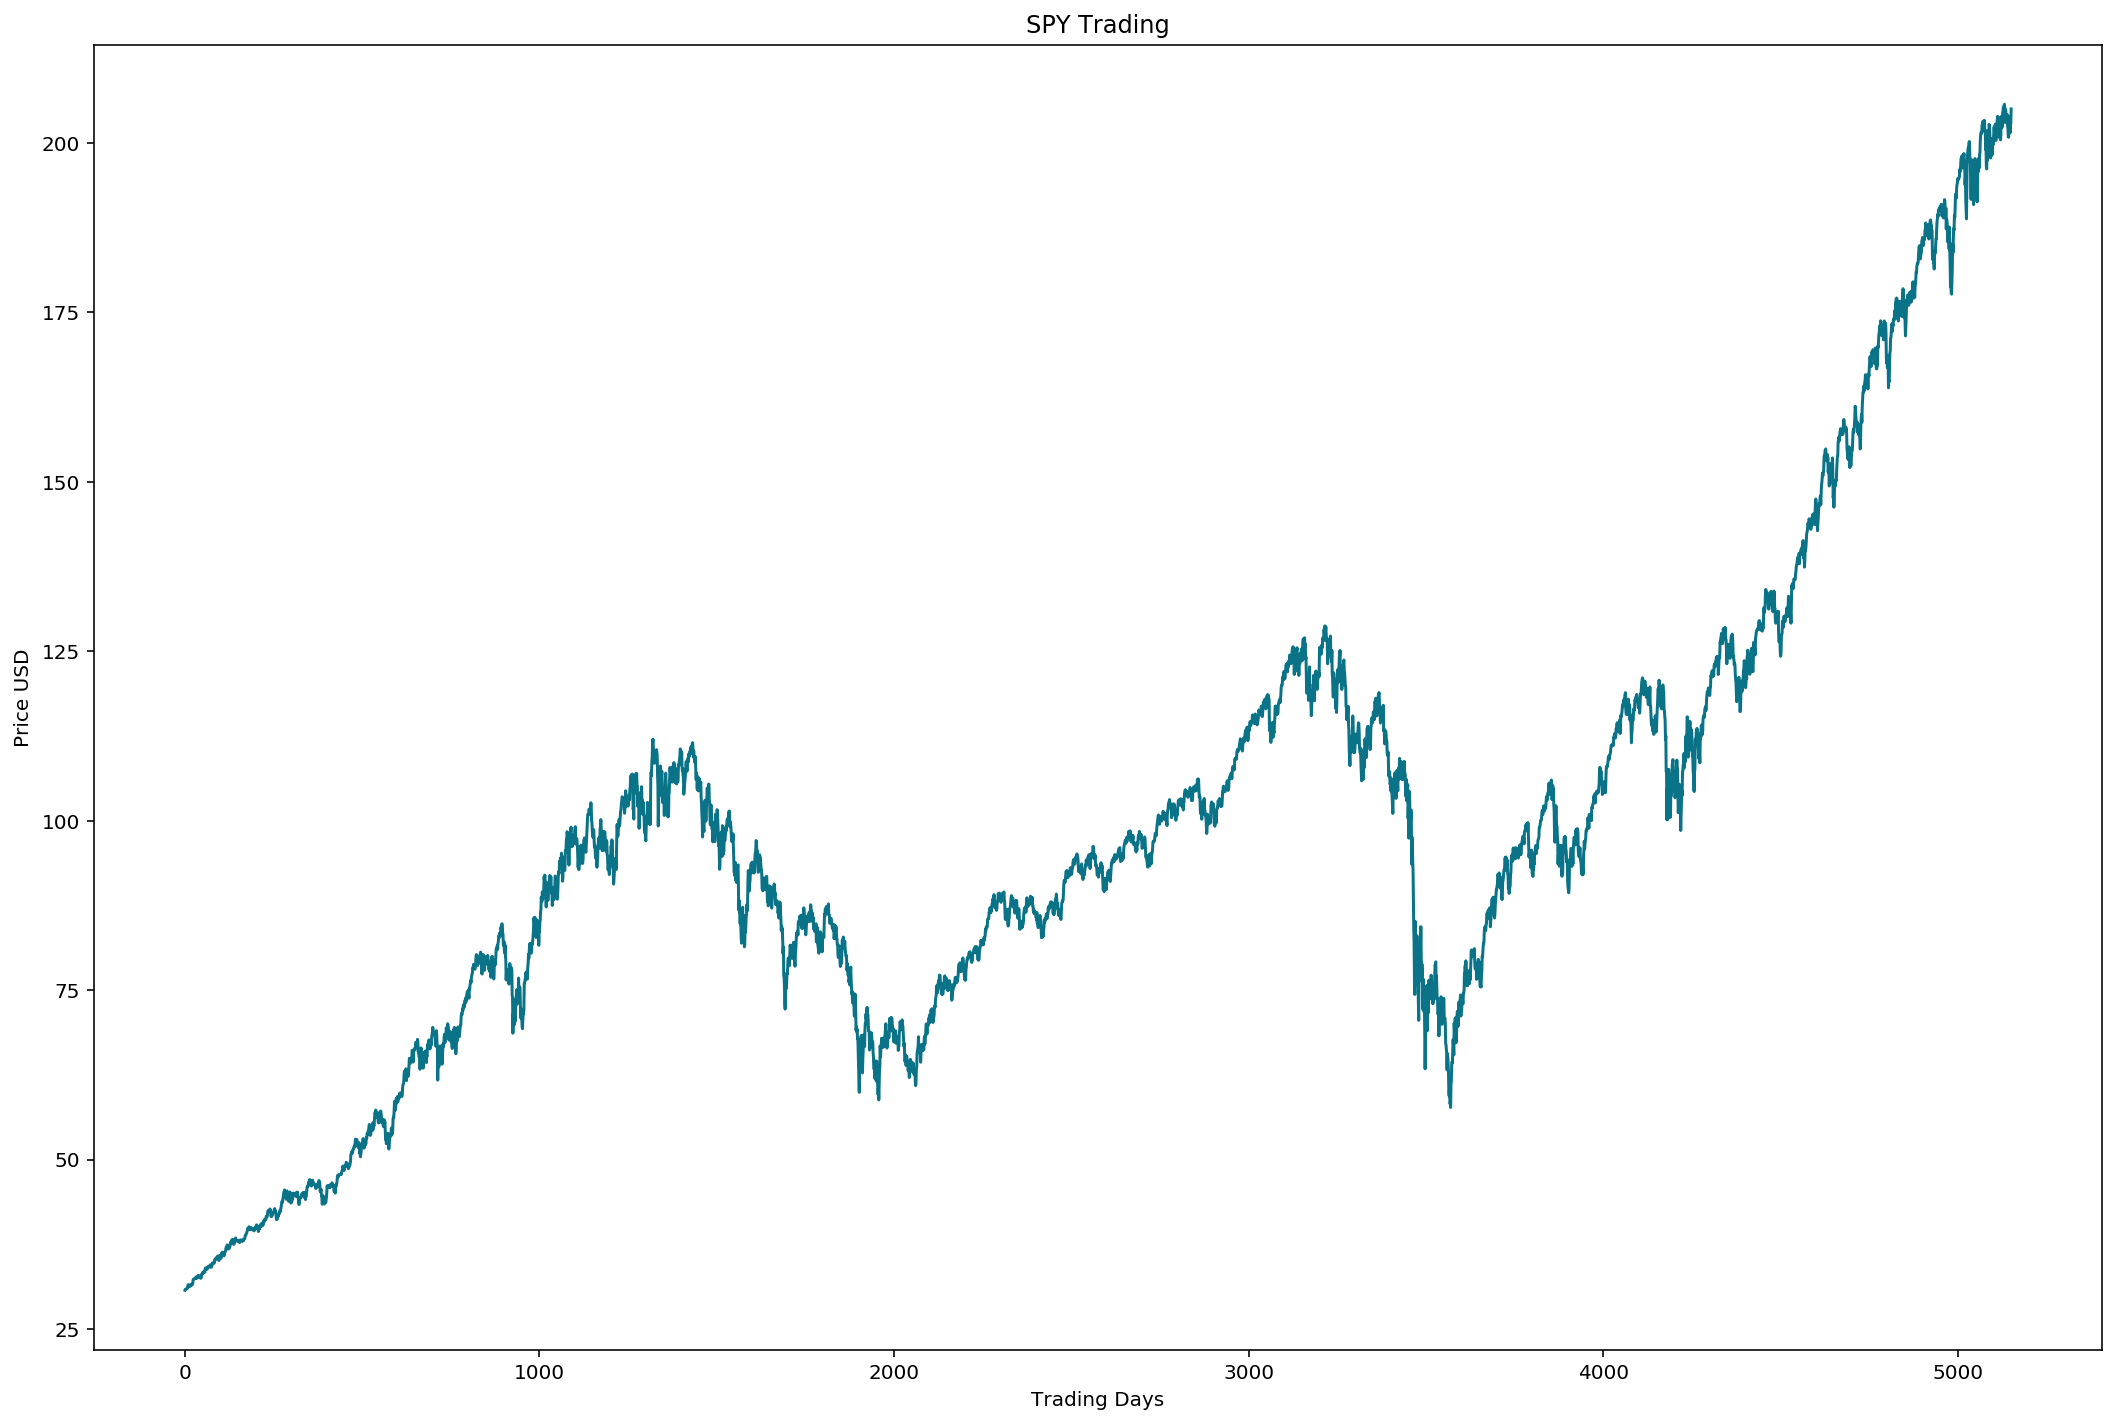

In [4]:
#Plot Basic Data
fig, ax = plt.subplots()
ax.plot(stock_df['Item'], stock_df['Adj_Close'], '#0A7388')

# format the coords message box
def price(x):
    return '$%1.2f' % x
#ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = price
ax.set_title(base_ticker + ' Trading')

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')

plt.show()

In [5]:
#Create numpy arrays for features and targets
X_all = []
y_all = []

#Convert dataframe columns to numpy arrays for scikit learn
for index, row in stock_df.iterrows():
    #print([np.array(row['Item'])])
    X_all.append([(row['Item'])])
    y_all.append([(row['Adj_Close'])])

#pprint(X_all)
pprint(y_all)

[[30.707108],
 [30.853865000000003],
 [30.853865000000003],
 [30.885253999999996],
 [30.916713],
 [30.948169],
 [30.969096999999998],
 [30.979628],
 [31.346386],
 [31.535063],
 [31.545528000000004],
 [31.51407],
 [31.335922999999998],
 [31.220623],
 [31.314996],
 [31.356917],
 [31.440759000000003],
 [31.472148999999998],
 [31.597912],
 [31.461686],
 [31.587449],
 [31.576984000000003],
 [31.765596000000002],
 [32.216265],
 [32.35249],
 [32.394411],
 [32.394411],
 [32.394411],
 [32.436332],
 [32.446863],
 [32.488784],
 [32.666931],
 [32.625009999999996],
 [32.499247],
 [32.488784],
 [32.729779],
 [32.782231],
 [32.866073],
 [32.604015999999994],
 [32.876536],
 [32.666931],
 [32.708852],
 [32.719317],
 [32.74031],
 [32.488784],
 [32.572626],
 [32.562095],
 [33.04422],
 [33.012764000000004],
 [33.253825],
 [33.190909999999995],
 [33.390053],
 [33.423297],
 [33.423297],
 [33.339001],
 [33.370561],
 [33.391668],
 [33.865817],
 [34.00278],
 [34.00278],
 [33.992261],
 [33.929072],
 [33.79204],

In [6]:
# Regularize the feature and target arrays and store min/max of input data for rescaling later
X_bounds = [min(X_all), max(X_all)]
X_bounds = [X_bounds[0][0], X_bounds[1][0]]
y_bounds = [min(y_all), max(y_all)]
y_bounds = [y_bounds[0][0], y_bounds[1][0]]

X_scaled, X_range = util.scale_range(np.array(X_all), input_range=X_bounds, target_range=[-1.0, 1.0])
y_scaled, y_range = util.scale_range(np.array(y_all), input_range=y_bounds, target_range=[-1.0, 1.0])

pprint(y_scaled)
print(y_range)

array([[-1.        ],
       [-0.99832271],
       [-0.99832271],
       ..., 
       [ 0.96421267],
       [ 0.96795653],
       [ 0.99207172]])
[30.707108000000002, 205.69991200000001]


In [7]:
# Define Test/Train Split 80/20
tt_split = .315
tti_split = int(math.floor(len(stock_df['Item'])*tt_split))

# Set up training and test sets
X_train = X_scaled[:-tti_split]
X_test = X_scaled[-tti_split:]

y_train = y_scaled[:-tti_split]
y_test = y_scaled[-tti_split:]

#pprint(X_train)
#pprint(X_test)

# Create dataframe for all training, testing, and predicted sets
results_df = pd.DataFrame(columns=['Item', 'Actual', 'Actual_Scaled', 'Train', 'Test', 'Test_Scaled', 'Predicted', 'Predicted_Scaled'])
results_df['Item'] = stock_df['Item']
results_df['Actual'] = stock_df['Adj_Close']
results_df['Actual_Scaled'] = y_scaled.flatten()
results_df['Train'][:-tti_split] = y_train.flatten()
results_df['Test'][-tti_split:] = stock_df['Adj_Close'][-tti_split:]
results_df['Test_Scaled'][-tti_split:] = y_test.flatten()

pprint(results_df)


      Item      Actual  Actual_Scaled     Train     Test Test_Scaled  \
0        0   30.707108      -1.000000        -1      NaN         NaN   
1        1   30.853865      -0.998323 -0.998323      NaN         NaN   
2        2   30.853865      -0.998323 -0.998323      NaN         NaN   
3        3   30.885254      -0.997964 -0.997964      NaN         NaN   
4        4   30.916713      -0.997604 -0.997604      NaN         NaN   
5        5   30.948169      -0.997245 -0.997245      NaN         NaN   
6        6   30.969097      -0.997006 -0.997006      NaN         NaN   
7        7   30.979628      -0.996885 -0.996885      NaN         NaN   
8        8   31.346386      -0.992694 -0.992694      NaN         NaN   
9        9   31.535063      -0.990537 -0.990537      NaN         NaN   
10      10   31.545528      -0.990418 -0.990418      NaN         NaN   
11      11   31.514070      -0.990777 -0.990777      NaN         NaN   
12      12   31.335923      -0.992813 -0.992813      NaN        

/Users/gilakos/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/gilakos/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/gilakos/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
# Create polynomial regression object
# http://scikit-learn.org/stable/auto_examples/linear_model/plot_robust_fit.html
model = make_pipeline(PolynomialFeatures(2), TheilSenRegressor(random_state=17))

# Train the model using the training sets
model.fit(X_train, y_train)

pprint(X_test)
# Create the predictions
initial_predictions = model.predict(X_test)
# Convert to correct numpy datastructure
predictions = []
for p in initial_predictions:
    predictions.append([p])
predictions = np.asarray(predictions)
#pprint(predictions)

predictions_rescaled, re_range = util.scale_range(predictions, input_range=[-1.0,1.0], target_range=y_range)
print(re_range)
print(predictions)
print(predictions_rescaled)

# Store the predictions
results_df['Predicted_Scaled'][-tti_split:] = predictions.flatten()
results_df['Predicted'][-tti_split:] = predictions_rescaled.flatten()

pprint(results_df)

/Users/gilakos/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[ 0.37060765],
       [ 0.37099592],
       [ 0.3713842 ],
       ..., 
       [ 0.99922345],
       [ 0.99961173],
       [ 1.        ]])
[-0.34327506356062398, -0.18715703169968076]
[[-0.18715703]
 [-0.18716598]
 [-0.18717503]
 ..., 
 [-0.34290782]
 [-0.34309139]
 [-0.34327506]]
[[ 101.82794312]
 [ 101.82716059]
 [ 101.82636863]
 ..., 
 [  88.20030957]
 [  88.18424802]
 [  88.16817704]]
      Item      Actual  Actual_Scaled     Train     Test Test_Scaled  \
0        0   30.707108      -1.000000        -1      NaN         NaN   
1        1   30.853865      -0.998323 -0.998323      NaN         NaN   
2        2   30.853865      -0.998323 -0.998323      NaN         NaN   
3        3   30.885254      -0.997964 -0.997964      NaN         NaN   
4        4   30.916713      -0.997604 -0.997604      NaN         NaN   
5        5   30.948169      -0.997245 -0.997245      NaN         NaN   
6        6   30.969097      -0.997006 -0.997006      NaN         NaN   
7        7   30.979628   

/Users/gilakos/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/gilakos/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


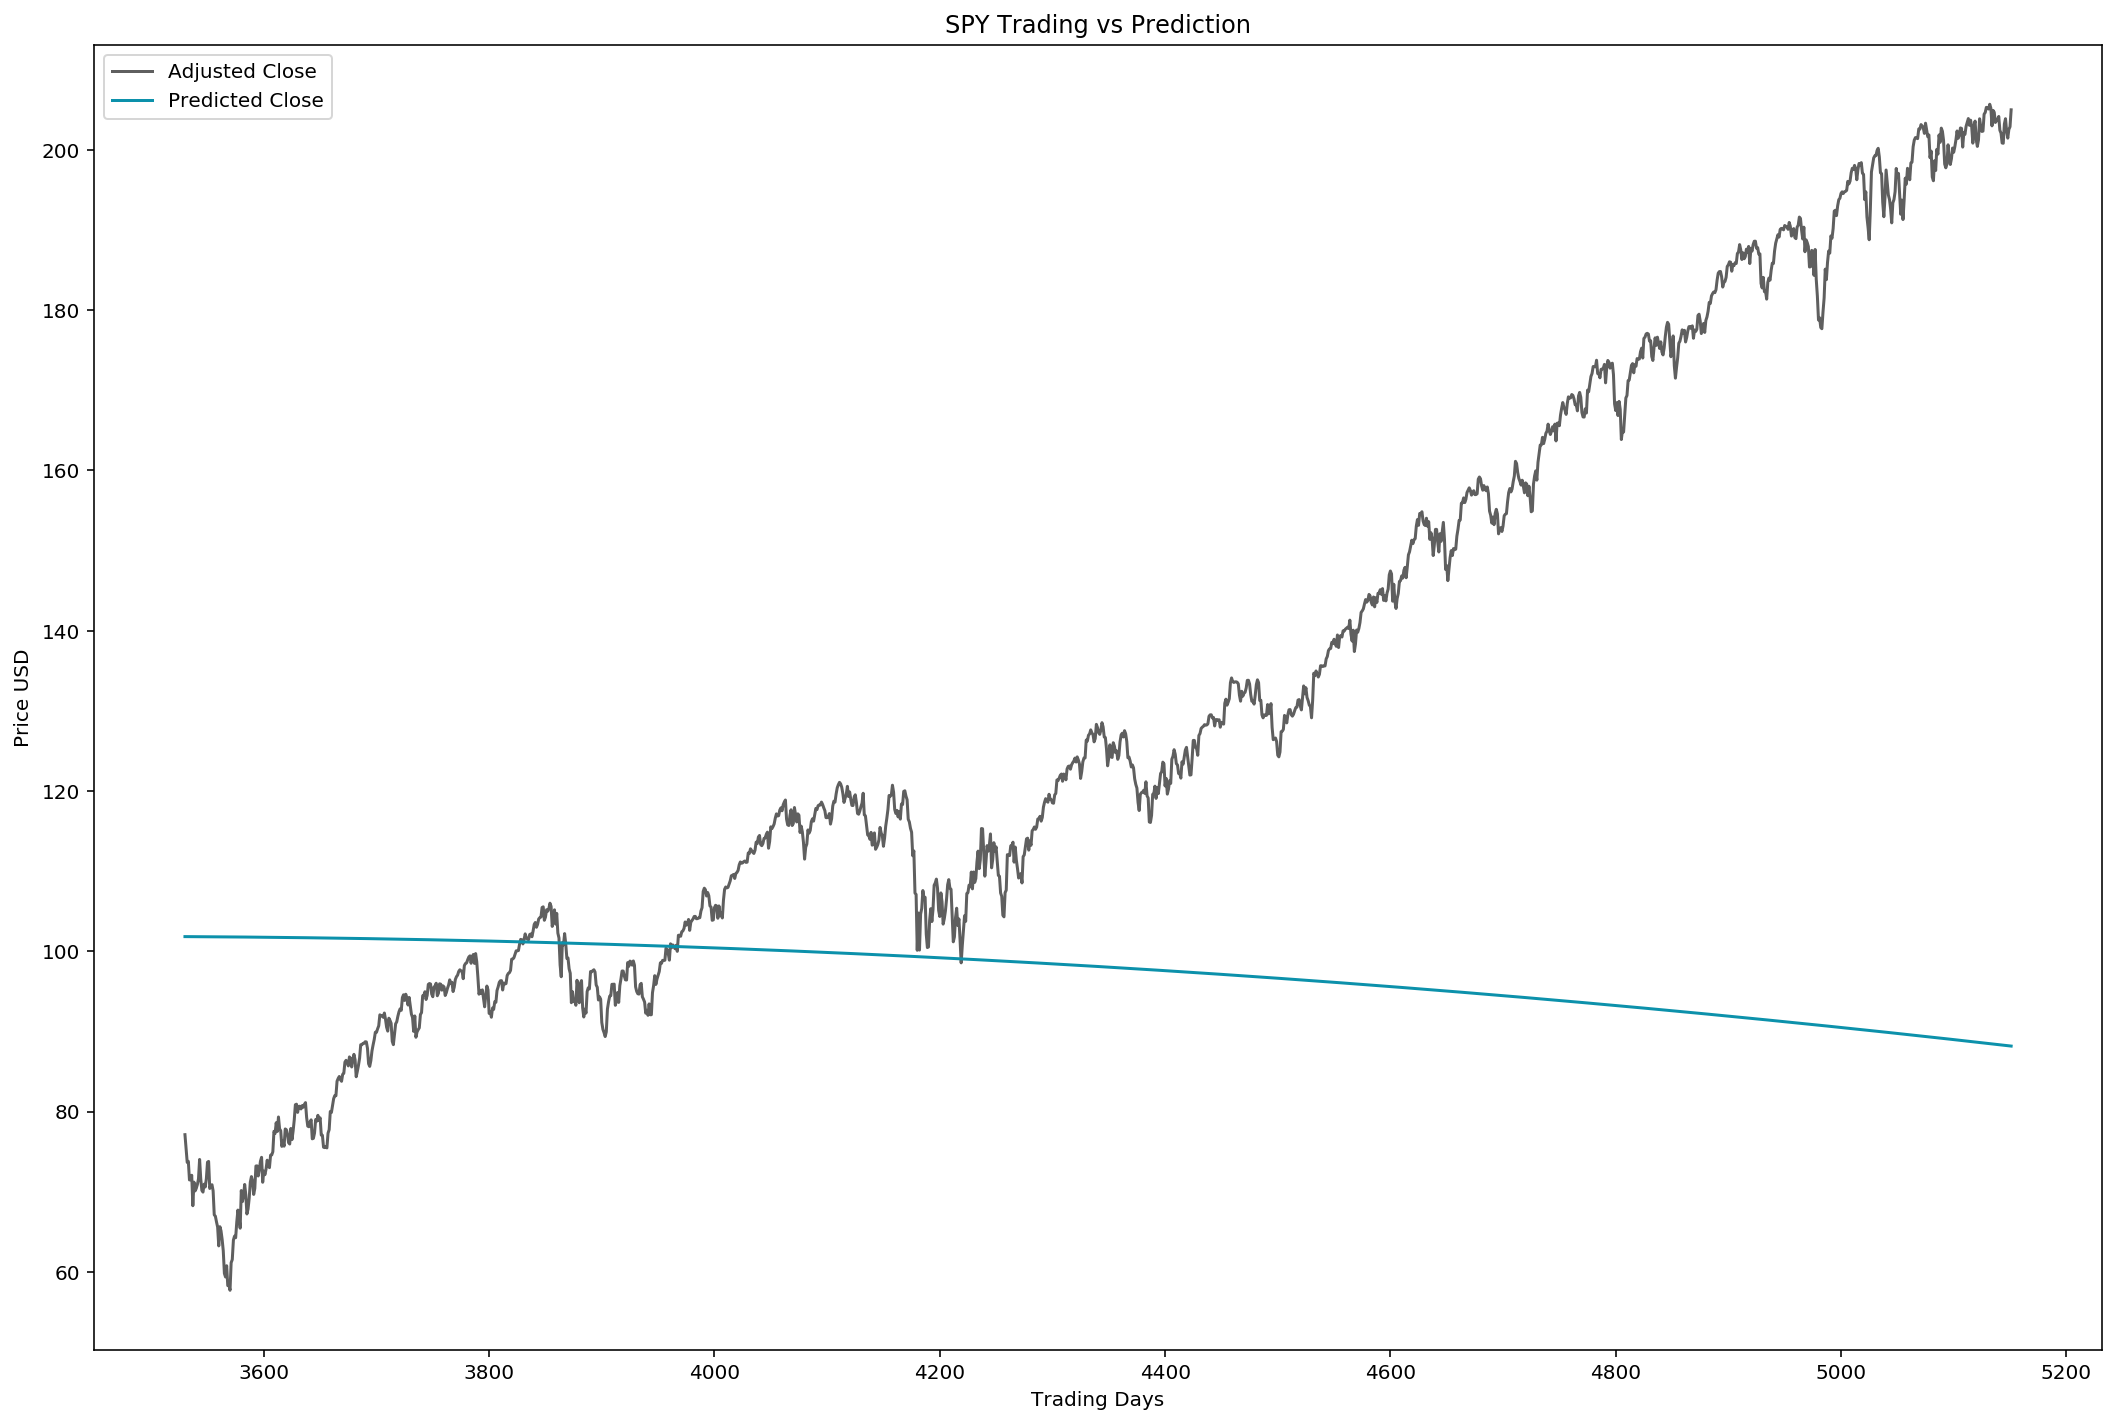

In [9]:
# Plot the training, testing, and predicted data

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(results_df['Test'],'#5F5F5F', label='Adjusted Close')
plt.plot(results_df['Predicted'], '#0C91AB', label='Predicted Close')

# Set title
ax.set_title(base_ticker + ' Trading vs Prediction')
ax.legend(loc='upper left')

plt.show()

In [11]:
# The mean squared error
print("Mean squared error: %.4f"
      % mean_squared_error(predictions, y_test))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.4f' % model.score(X_test, y_test))

Mean squared error: 0.3895
Variance score: -1.0154


# Study Insights:

From Linear to Polynomial, MSE performed worse: 

0.1219 to 0.3895


# Log of Results:

### SPY
Mean squared error: 0.390

Variance score: -1.015

### GE


### MSFT


### AAPL
